In [1]:
%matplotlib inline
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

import numpy as np

import scipy.signal as sps

from IPython.display import HTML
import IPython.display 
from io import BytesIO
from base64 import b64encode
from PIL import Image
from datetime import datetime

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 32, 24

In [2]:
# Draws a uint16 image as a uint8, defaults to one frame
def drawdata(bm, x = 1820, y = 525, hscale = 1, vscale = 1, outsize = None):
#    bmf = np.float32(bm) / 65536.0
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
#    imshow(np.asarray(im))
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())
                         
#drawdata(data)                         

In [3]:
from scipy import interpolate

# This uses numpy's interpolator, which works well enough
def scale(buf, begin, end, tgtlen):
#        print("scaling ", begin, end, tgtlen)
        ibegin = np.floor(begin)
        iend = np.floor(end)
        linelen = end - begin

        dist = iend - ibegin + 1
        arr = np.linspace(0, dist, num=dist)
#       print(arr, dist, begin, ibegin, ibegin + dist)
        spl = interpolate.splrep(arr, buf[ibegin:ibegin + dist])
        arrout = np.linspace(begin - ibegin, linelen, tgtlen)

        return interpolate.splev(arrout, spl)
    

In [4]:
# This follows the default scale in lddecodercuda
minire = -60
maxire = 140

hz_ire_scale = (9300000 - 8100000) / 100
minn = 8100000 + (hz_ire_scale * -60)

out_scale = 65534.0 / (maxire - minire)

def RawToIRE(data):
    return (np.float32(data) / out_scale) + minire

def IREToRaw(data):
    return np.uint16((data - minire) * out_scale)

In [5]:
FSC = 8
freq_mhz = (315.0 / 88.0) * FSC
freq_hz = freq_mhz * 1000000.0
linelen = FSC * 227.5

synctrig = IREToRaw(-20)
rot_lowtrig = IREToRaw(-50) # should only happen during rot

# This is designed to smooth out small rot etc and clarify the sync intervals
f_slpf_b = sps.firwin(49, 100000/freq_hz)
f_slpf_a = [1.0]
f_slpf_offset = 24

# This is used to remove HF noise in rot detection check later
f_lpf_b = sps.firwin(49, 2000000/freq_hz)
f_lpf_a = [1.0]
f_lpf_offset = 24

burstfreq = 1000000 * 315/88.0

# This filter focuses on the color burst in an attempt to improve alignment on noisy disks
f_burst_bpf_b = sps.firwin(49, [(burstfreq-250000)/freq_hz, (burstfreq+250000)/freq_hz])
f_burst_bpf_a = [1.0]
f_burst_bpf_offset = 24

# This does the *real* work of detecting syncs...

f_syncid_b, f_syncid_a = sps.butter(3, 0.002)
f_syncid_offset = 320


In [223]:
infd = open('rotplane.ld', 'rb')

bufsize = 1820 * 525 * 30
inbuf = infd.read(bufsize * 2)
data = np.fromstring(inbuf, 'uint16', len(inbuf)//2)

lpfdata = sps.lfilter(f_lpf_b, f_lpf_a, data)[f_lpf_offset:]

bpfdata = sps.lfilter(f_burst_bpf_b, f_burst_bpf_a, data)[f_lpf_offset:]

# Before official rot correction, we need to remove low spikes to avoid confusing the sync filter
data_despike = data.copy()
data_despike[np.where(data < rot_lowtrig)] = IREToRaw(0)
data_despike[np.where(data > IREToRaw(120))] = IREToRaw(120)

slpfdata = sps.lfilter(f_slpf_b, f_slpf_a, data_despike)[f_slpf_offset:]
sdata = slpfdata < synctrig

sfdata = sps.lfilter(f_syncid_b, f_syncid_a, sdata)[f_syncid_offset:]
# Clip sfdata so there are no false low peaks
sfdata[np.where(sfdata < .05)] = .05



In [224]:

def inrange(x, mi, ma):
    return (x >= mi) and (x <= ma)

def inrange_fsc(x, mi, ma):
    xf = x / FSC
    return (xf >= mi) and (xf <= ma)


In [227]:
# Previously written color burst detection

# set up sync color heterodyne table first 
out_fsc = 8
out_linelen = 227.5 * out_fsc

bhet = np.empty(4096, dtype=np.complex)
for i in range(0, 4096):
        radian = (i / (out_fsc)) * 2 * np.pi
        bhet[i] = complex(np.cos(radian + (33.0/180.0)), -(np.sin(radian + (33.0/180.0))))
        bhet[i] = complex(np.cos(radian + (0.0/180.0)), -(np.sin(radian + (0.0/180.0))))

color_filter = sps.firwin(17, 0.1 / (freq_mhz / 2), window='hamming')

obhet_levels = None
obhet_angles = None

def burst_detect(data):
    global obhet_levels, obhet_angles
        
    level = 0
    phase = 0

    data = data.astype(np.float32)
    data -= np.mean(data)
        
    obhet = bhet[0:len(data)] * data
        
    obhet_filt = sps.lfilter(color_filter, [1.0], obhet)
        
    obhet_levels = np.fabs(np.absolute(obhet_filt))

    peak = np.argmax(obhet_levels)
    
    level = obhet_levels[peak]
    phase = np.angle(obhet_filt[peak])
    
    return [level, phase]
    
def wrap_angle(angle, tgt):
    adjust = tgt - angle
        
    if (adjust > (np.pi)):
        adjust -= 2 * np.pi
    elif (adjust < (-np.pi)):
        adjust += 2 * np.pi

    return adjust

phasemult = 1 / (2 * np.pi) * FSC

#burst_detect(data[bbegin:bend])

In [258]:
# This code is intended for eventual C conversion (w/possible AVX use) and is not intended to be optimal python code.

def find_sync(data, tgt, pad = 6, chunksize = 16, dbg = False):
    # Transition targets - to is esp. important because rot can go to -50 or below
    fr = (IREToRaw(-5), IREToRaw(12.5))
    to = (IREToRaw(-45), IREToRaw(-30))
    
    tgt = int(tgt)
    
    limit = len(data) - chunksize # if len(data) < limit else limit
    
    clen = (tgt // chunksize) + pad
    count = np.zeros(clen)
    
    # states: 0 = searching, 1 = found/looking for peak, 2 = done
    
    peak = 0
    state = 0
    c = 0
    while state < 2:
        bloc = c % clen

        subset = data[c * chunksize: (c + 1) * chunksize] 
        count[bloc] = sum(np.logical_and(subset > to[0], subset < to[1]))
        
        csum = np.sum(count)
        if (csum >= tgt) and (csum > peak):
            peak = csum
            state = 1
        elif state == 1:
            if csum < peak:
                state = 2

        if dbg and csum > 0:
            print(c * chunksize, sum(subset > to[0]), sum(subset < to[1]), np.sum(count))
        
        c += 1
        if c >= (limit // chunksize):
            return None if (peak == 0) else ((c - 1) * chunksize)
        
    return (c - 1) * chunksize
    

In [239]:
ts = datetime.now()    

# first pass - rough vsync detection (optional and may not be used on AVX version)

loc = 0
#loc = 250000
field_len = int(FSC * 227.5 * 280)

fields = []

while len(data) > (loc + field_len):
    #rv = find_sync(data[loc: loc + field_len], tgt = int(60 * FSC), chunksize=int(227.5 * FSC), pad = 2)
    rv = find_sync(data[loc: loc + field_len], tgt = int(60 * FSC), chunksize=16, pad = 2)
    if rv == None:
        print("no valid vsync found")
    else:
        first_vsync = None
        last_vsync = None

        vloc = loc + rv - (910 * 8)
        vcount = 0
        rv = 0
        while rv != None:
            # First pass may return any of the 6 syncs, with padding

            vend = vloc + int(227.5 * 6 * FSC) if vcount == 0 else vloc + int(227.5 * FSC)

    #        rv = find_sync(data[vloc:vend], tgt = (60 * FSC), chunksize=int(16 * FSC), pad = 2)
            rv = find_sync(data[vloc:vend], tgt = (60 * FSC), chunksize=16, pad = 2)
            if rv is not None:
                print('vsync pulse at:', vloc + rv)
                vcount += 1

                if first_vsync is None:
                    first_vsync = vloc + rv
                else:
                    last_vsync = vloc + rv

                vloc += rv

    first_vsync -= int(127.5 * FSC)  # rewind 1 line so we don't calc the beginning

    presync = data[first_vsync - int(227.5 * FSC * 4.5):first_vsync]
    postsync = data[last_vsync: last_vsync + int(227.5 * FSC * 4.25)]

    presync_t = np.sum(np.logical_and(presync > IREToRaw(-45), presync < IREToRaw(-35)))
    postsync_t = np.sum(np.logical_and(postsync > IREToRaw(-45), postsync < IREToRaw(-35)))

    print(first_vsync, last_vsync, presync_t, postsync_t, datetime.now() - ts)
    
    loc = last_vsync
    
    fields.append((loc, presync_t > postsync_t))

vsync pulse at: 101024
vsync pulse at: 102080
vsync pulse at: 102992
vsync pulse at: 103904
vsync pulse at: 105680
100004 105680 530 489 0:00:00.382452
vsync pulse at: 578912
vsync pulse at: 579712
vsync pulse at: 580736
vsync pulse at: 581648
vsync pulse at: 582560
vsync pulse at: 583472
577892 583472 462 581 0:00:01.933649
vsync pulse at: 1056896
vsync pulse at: 1057808
vsync pulse at: 1058720
vsync pulse at: 1059616
vsync pulse at: 1060544
vsync pulse at: 1061456
1055876 1061456 584 454 0:00:03.486216
vsync pulse at: 1534784
vsync pulse at: 1535504
vsync pulse at: 1536608
vsync pulse at: 1537520
vsync pulse at: 1538368
vsync pulse at: 1539344
1533764 1539344 391 524 0:00:05.014379
vsync pulse at: 2012336
vsync pulse at: 2013248
vsync pulse at: 2014160
vsync pulse at: 2015072
vsync pulse at: 2015968
vsync pulse at: 2016880
2011316 2016880 556 455 0:00:06.546013
vsync pulse at: 2490080
vsync pulse at: 2490992
vsync pulse at: 2491904
vsync pulse at: 2492816
vsync pulse at: 2493728
vsyn

KeyboardInterrupt: 

1 False 4.74289625883 2404.74289626 1819.13436544 227.39179568
2 False 15.8555995673 4223.85559957 1819.11270331 454.780883593
3 False 11.3232876658 6043.32328767 1819.4676881 682.214344606
4 False 6.28475511074 7862.28475511 1818.96146744 909.584528036
5 False 1.32770502567 9681.32770503 1819.04294991 1136.96489678
6 False 12.7659107596 11500.7659108 1819.43820573 1364.39467249
err1 7 13193 26243
7 True -8.00136444904 12865.1605833 1364.39467249 1364.39467249
8 False 3.5184442699 15139.5184443 2274.35786102 1648.68940512
9 False 14.7770106941 16958.7770107 1819.25856642 1876.09672592
err 1818.81944601 1876.09672592
10 True 9.59645670652 18834.8737366 1876.09672592 1876.09672592
err 1762.28230095 1876.09672592
11 True 5.15603756905 20710.9704625 1876.09672592 1876.09672592
err 1706.03155836 1876.09672592
12 True 1.00202089548 22587.0671885 1876.09672592 1876.09672592
err 1649.03146122 1876.09672592
13 True 12.0986496806 24463.1639144 1876.09672592 1876.09672592
err 1592.28745717 1876.0

/home/cpage/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:40: RuntimeWarning: overflow encountered in ushort_scalars
/home/cpage/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


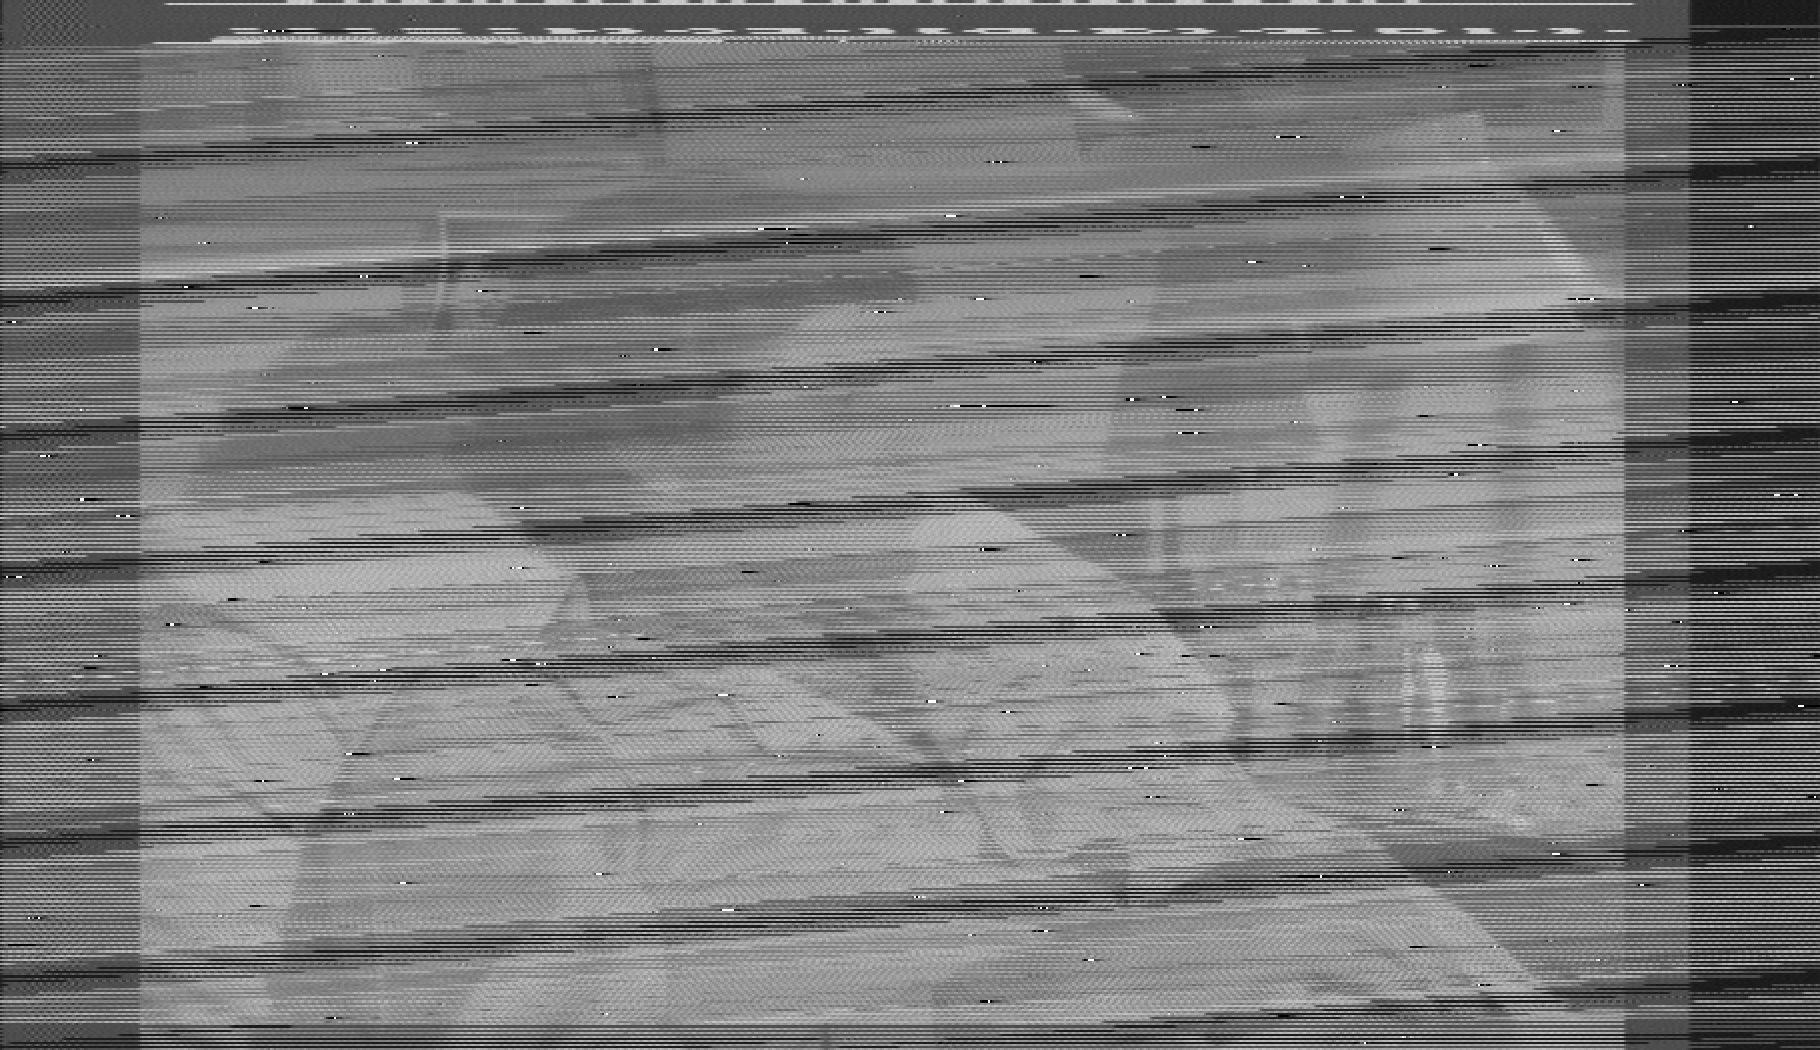

In [330]:
def phase1(data, begin):
    hsync_err = np.full(253, False, dtype=np.bool)
    
    hloc = begin
    peaks = []
    for line in range(0, 253):
        rv = find_sync(data[hloc:hloc * (80 * FSC)], tgt = (7 * FSC), chunksize=16, pad = 4, dbg = False)
        if rv is None:
            print('oops!')
            break
            
        if (rv > 1800) and (line >= 1):
            hsync_err[line] = True
            peaks.append(peaks[-1] + 1820)
            print('eek ', line, peaks[-1])
            hloc += 1800
        else:
            peaks.append(hloc + rv - begin)
            #print('peak ', peaks[-1])
            hloc += rv + 1600            
            
    return peaks, hsync_err

def phase2(data, begin, peaks, hsync_err):
    lbegin = np.zeros(253, dtype=np.float64)
    lend = np.zeros(253, dtype=np.float64)

    avg = np.full(8, 0, dtype=np.float64)
    avgi = 0

    for line in range(0, 253):
        err = False
        lbegin_subset = data[begin + peaks[line] - (1 * FSC): begin + peaks[line] + (4 * FSC)]

        if np.min(lbegin_subset) < IREToRaw(-55) or np.max(lbegin_subset) > IREToRaw(20):
            print('err1', line, np.min(lbegin_subset), np.max(lbegin_subset))
            err = True

        curlbegin = np.where(lbegin_subset > IREToRaw(-20))[0][0]
        curlbegin = curlbegin - (lbegin_subset[curlbegin] - IREToRaw(-20)) / (lbegin_subset[curlbegin] - lbegin_subset[curlbegin - 1])

        curlbegin -= (1 * FSC) # correction to get the actual beginning of line

        lbegin[line] = peaks[line] + curlbegin

        if avgi >= len(avg):
            if (hsync_err[line] == True) or np.fabs((lbegin[line] - lbegin[line - 1]) - np.mean(avg)) > (.5 * FSC):
                print('err', lbegin[line] - lbegin[line - 1], np.mean(avg))
                err = True

        if (line > 2) and err:
            lbegin[line] = lbegin[line - 1] + np.mean(avg)
        elif line >= 1:
            avg[avgi % len(avg)] = lbegin[line] - lbegin[line - 1]
            avgi += 1
            
        if line >= 1:
            lend[line - 1] = lbegin[line]
            print(line, err, curlbegin, lbegin[line], lbegin[line] - lbegin[line - 1], np.mean(avg))
            
    return lbegin, lend, avg


# not-LPF sync data version

framebuf = np.zeros(910 * 504, dtype=np.uint16)
lineloc = np.zeros((504, 2), dtype=np.float32)

ts = datetime.now()

fnum = -1
sf = 4
for f in range(sf, len(fields)):
    fs = fields[f][0]
    
    if fnum == -1 and fields[f][1] == False:
        continue
            
    fnum += 1

    # 'start' our field data about 170 samples before the first proper sync
    if fields[f][1] == True:
        begin = fs + int(757 * FSC)
    else:
        begin = fs + int(871 * FSC)

    peaks, hsync_err = phase1(data, begin)
    
    if len(peaks) < 253:
        break

    lbegin, lend, avg = phase2(data, begin, peaks, hsync_err)

    adjust = np.zeros(253, dtype=np.float32)
    
    tgt = -1
    lasterr = -2
    last_hsync_err = 0
    
    cbonly = (400 / 1820)
    nextcb = (1920 / 1820)

    for line in range(0, 252):
        if line > 1:
            avg[1:] = avg[:-1]
            avg[0] = lbegin[line] - lbegin[line - 1]
            
        linelen = lend[line] - lbegin[line]

        # faster but with this scaler not 100% accurate
        sline1s = scale(data[begin:], lbegin[line], lbegin[line] + (linelen * cbonly), 400)
        burst = burst_detect(sline1s[28:90])
        
        if line < 5:
            tgt = np.pi if np.fabs(burst[1]) > (np.pi / 2.0) else 0
        else:
            tgt = 0 if np.fabs(tgt) == np.pi else np.pi
                        
        adjust[line] = -1.00 * phasemult * wrap_angle(tgt, burst[1])
        lbegin[line] += adjust[line]
        lend[line] = lbegin[line + 1] + adjust[line]
        
        # Second pass - bring the next line's burst in line with this one to stabilize the whole line
        
        linelen = lend[line] - lbegin[line]
        sline1 = scale(data[begin:], lbegin[line], lbegin[line] + (linelen * nextcb), 1920)
        
        burst = burst_detect(sline1[28:90])
        burst2 = burst_detect(sline1[1844:1910])
        
        #print(line, burst[1], burst2[1])

        adjust[line + 1] = -1.00 * phasemult * wrap_angle(burst[1], burst2[1])
        lend[line] += adjust[line + 1]
        
    for line in range(0, 252):    
        
        if None: # line < 250:
            slinet = scale(data[begin:], lbegin[line], lbegin[line + 2], 3640)
            burst1 = burst_detect(slinet[20:100])
            burst2 = burst_detect(slinet[1840:1920])
        
            print(line, o1[line], burst1[1], burst2[1])

        sline = scale(data[begin:], lbegin[line], lend[line], 910)
            
        l = (line * 2) + (0 if fields[f][1] else 1)
        
        framebuf[l * 910:((l + 1) * 910)] = sline[0:910]
        
    if fnum == 1:
        break
        
#0 56.1302449872 541.0 0.0
#1 55.8597994688 2361.0 2416.85979947
#2 55.4330637771 4181.0 4236.43306378
#3 55.9427313914 6000.0 6055.94273139        
        
print(len(data), datetime.now() - ts)
drawdata(framebuf, x = 910, hscale = 2, vscale = 2)


0 56.1302449872 541.0 0.0
1 55.8597994688 2361.0 2416.85979947
2 55.4330637771 4181.0 4236.43306378
3 55.9427313914 6000.0 6055.94273139
4 55.4875373235 7820.0 7875.48753732
5 55.0461234184 9640.0 9695.04612342
6 55.687925094 11459.0 11514.6879251
7 55.08986991 13279.0 13334.0898699
8 55.7585653347 15098.0 15153.7585653
9 55.2648240228 16918.0 16973.264824
10 55.7454461007 18737.0 18792.7454461
11 55.4145314076 20557.0 20612.4145314
12 55.5535163603 22376.0 22431.5535164
13 56.1832606825 24195.0 24251.1832607
14 55.5324887265 26015.0 26070.5324887
15 56.0869852193 27834.0 27890.0869852
16 55.2829565106 29654.0 29709.2829565
17 55.6658044336 31473.0 31528.6658044
18 55.9009111769 33292.0 33347.9009112
19 55.3299507903 35112.0 35167.3299508
20 55.4326264336 36931.0 36986.4326264
21 55.8860806954 38750.0 38805.8860807
22 56.09607317 40569.0 40625.0960732
23 55.3735027769 42389.0 42444.3735028
24 55.5202113255 44208.0 44263.5202113
25 55.7637012954 46027.0 46082.7637013
26 55.9290691252 47

/home/cpage/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:41: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/cpage/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:47: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/cpage/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


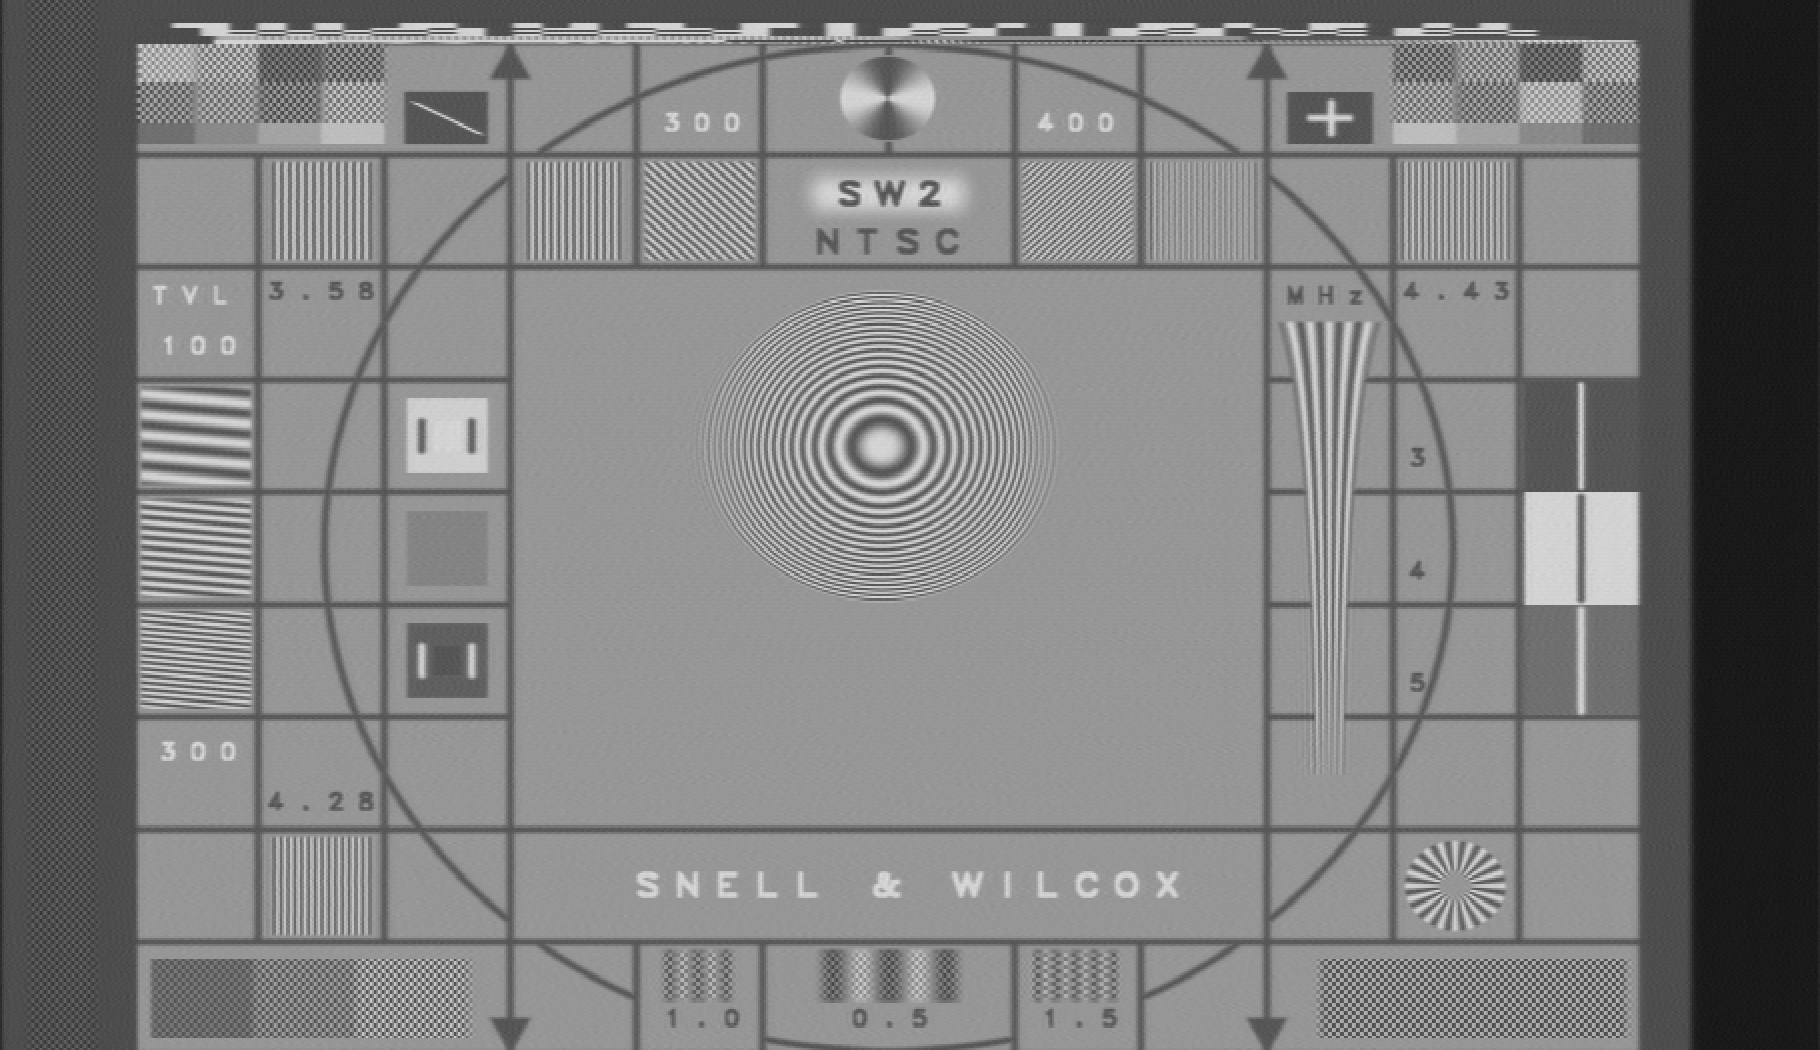

In [214]:
# LPF sync data version

framebuf = np.zeros(910 * 504, dtype=np.uint16)
lineloc = np.zeros((504, 2), dtype=np.float32)

ts = datetime.now()

fnum = -1
sf = 0
for f in range(0, len(fields)):
    fs = fields[f][0]
    
    if fnum == -1 and fields[f][1] == False:
        continue
            
    fnum += 1

    # 'start' our field data about 170 samples before the first proper sync
    if fields[f][1] == True:
        begin = fs + int(757 * FSC)
    else:
        begin = fs + int(871 * FSC)

    subset = sfdata[begin:begin + int(FSC * 227.5 * 255)]
    peaksr = np.logical_and((subset[1:-1] > subset[2:]), (subset[1:-1] > subset[:-2]))
    peaks = np.where(peaksr)[0].astype(np.float64)
    
    if len(peaks) < 253:
        break

    lbegin = np.zeros(253, dtype=np.float64)
    lend = np.zeros(253, dtype=np.float64)
    
    avg = np.full(8, ((peaks[250]-peaks[1])/249), dtype=np.float64)

    adjust = np.zeros(253, dtype=np.float32)
    
    tgt = -1
    lasterr = -2
    for line in range(0, 253):
        lbegin_subset = slpfdata[begin + peaks[line]: begin + peaks[line] + (10 * FSC)]
        
        curlbegin = np.where(lbegin_subset > IREToRaw(-20))[0][0]
        curlbegin = curlbegin - (lbegin_subset[curlbegin] - IREToRaw(-20)) / (lbegin_subset[curlbegin] - lbegin_subset[curlbegin - 1])
        #curlbegin += begin + peaks[line]

        dsub = lpfdata[begin + peaks[line] + curlbegin - (10 * FSC):begin + peaks[line] + curlbegin + (10 * FSC)]
        if (np.min(dsub) < IREToRaw(-45) or np.max(dsub) > IREToRaw(10)) or(curlbegin < 55) or (curlbegin > 58) and (line > 2):
            lbegin[line] = lbegin[line - 1] + (lbegin[line - 1] - lbegin[line - 2])
        else:
            lbegin[line] = peaks[line] + curlbegin
            
        if line >= 1:
            lend[line - 1] = lbegin[line]
            
        print(line, curlbegin, peaks[line], lend[line - 1])

    cbonly = (400 / 1820)
    nextcb = (1920 / 1820)

    for line in range(0, 252):
        if line > 1:
            avg[1:] = avg[:-1]
            avg[0] = lbegin[line] - lbegin[line - 1]
            
        # First pass - adjust this line's burst
            
        linelen = lend[line] - lbegin[line]
    
        # slower
#        sline1 = scale(data[begin:], lbegin[line], lbegin[line] + (linelen * nextcb), 1920)
#        burst = burst_detect(sline1[28:90])

        # faster but with this scaler not 100% accurate
        sline1s = scale(data[begin:], lbegin[line], lbegin[line] + (linelen * cbonly), 400)
        burst = burst_detect(sline1s[28:90])
        
        if line < 5:
            tgt = np.pi if np.fabs(burst[1]) > (np.pi / 2.0) else 0
        else:
            tgt = 0 if np.fabs(tgt) == np.pi else np.pi
                        
        adjust[line] = -1.00 * phasemult * wrap_angle(tgt, burst[1])
        lbegin[line] += adjust[line]
        lend[line] = lbegin[line + 1] + adjust[line]
        
        # Second pass - bring the next line's burst in line with this one to stabilize the whole line
        
        linelen = lend[line] - lbegin[line]
        sline1 = scale(data[begin:], lbegin[line], lbegin[line] + (linelen * nextcb), 1920)
        
        burst = burst_detect(sline1[28:90])
        burst2 = burst_detect(sline1[1844:1910])
        
        #print(line, burst[1], burst2[1])

        adjust[line + 1] = -1.00 * phasemult * wrap_angle(burst[1], burst2[1])
        lend[line] += adjust[line + 1]
        
    for line in range(0, 252):    
        
        if None: # line < 250:
            slinet = scale(data[begin:], lbegin[line], lbegin[line + 2], 3640)
            burst1 = burst_detect(slinet[20:100])
            burst2 = burst_detect(slinet[1840:1920])
        
            print(line, o1[line], burst1[1], burst2[1])

        sline = scale(data[begin:], lbegin[line], lend[line], 910)
            
        l = (line * 2) + (0 if fields[f][1] else 1)
        
        framebuf[l * 910:((l + 1) * 910)] = sline[0:910]
        
    if fnum == 1:
        break
        
print(len(data), datetime.now() - ts)
drawdata(framebuf, x = 910, hscale = 2, vscale = 2)


/home/cpage/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app
/home/cpage/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/home/cpage/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


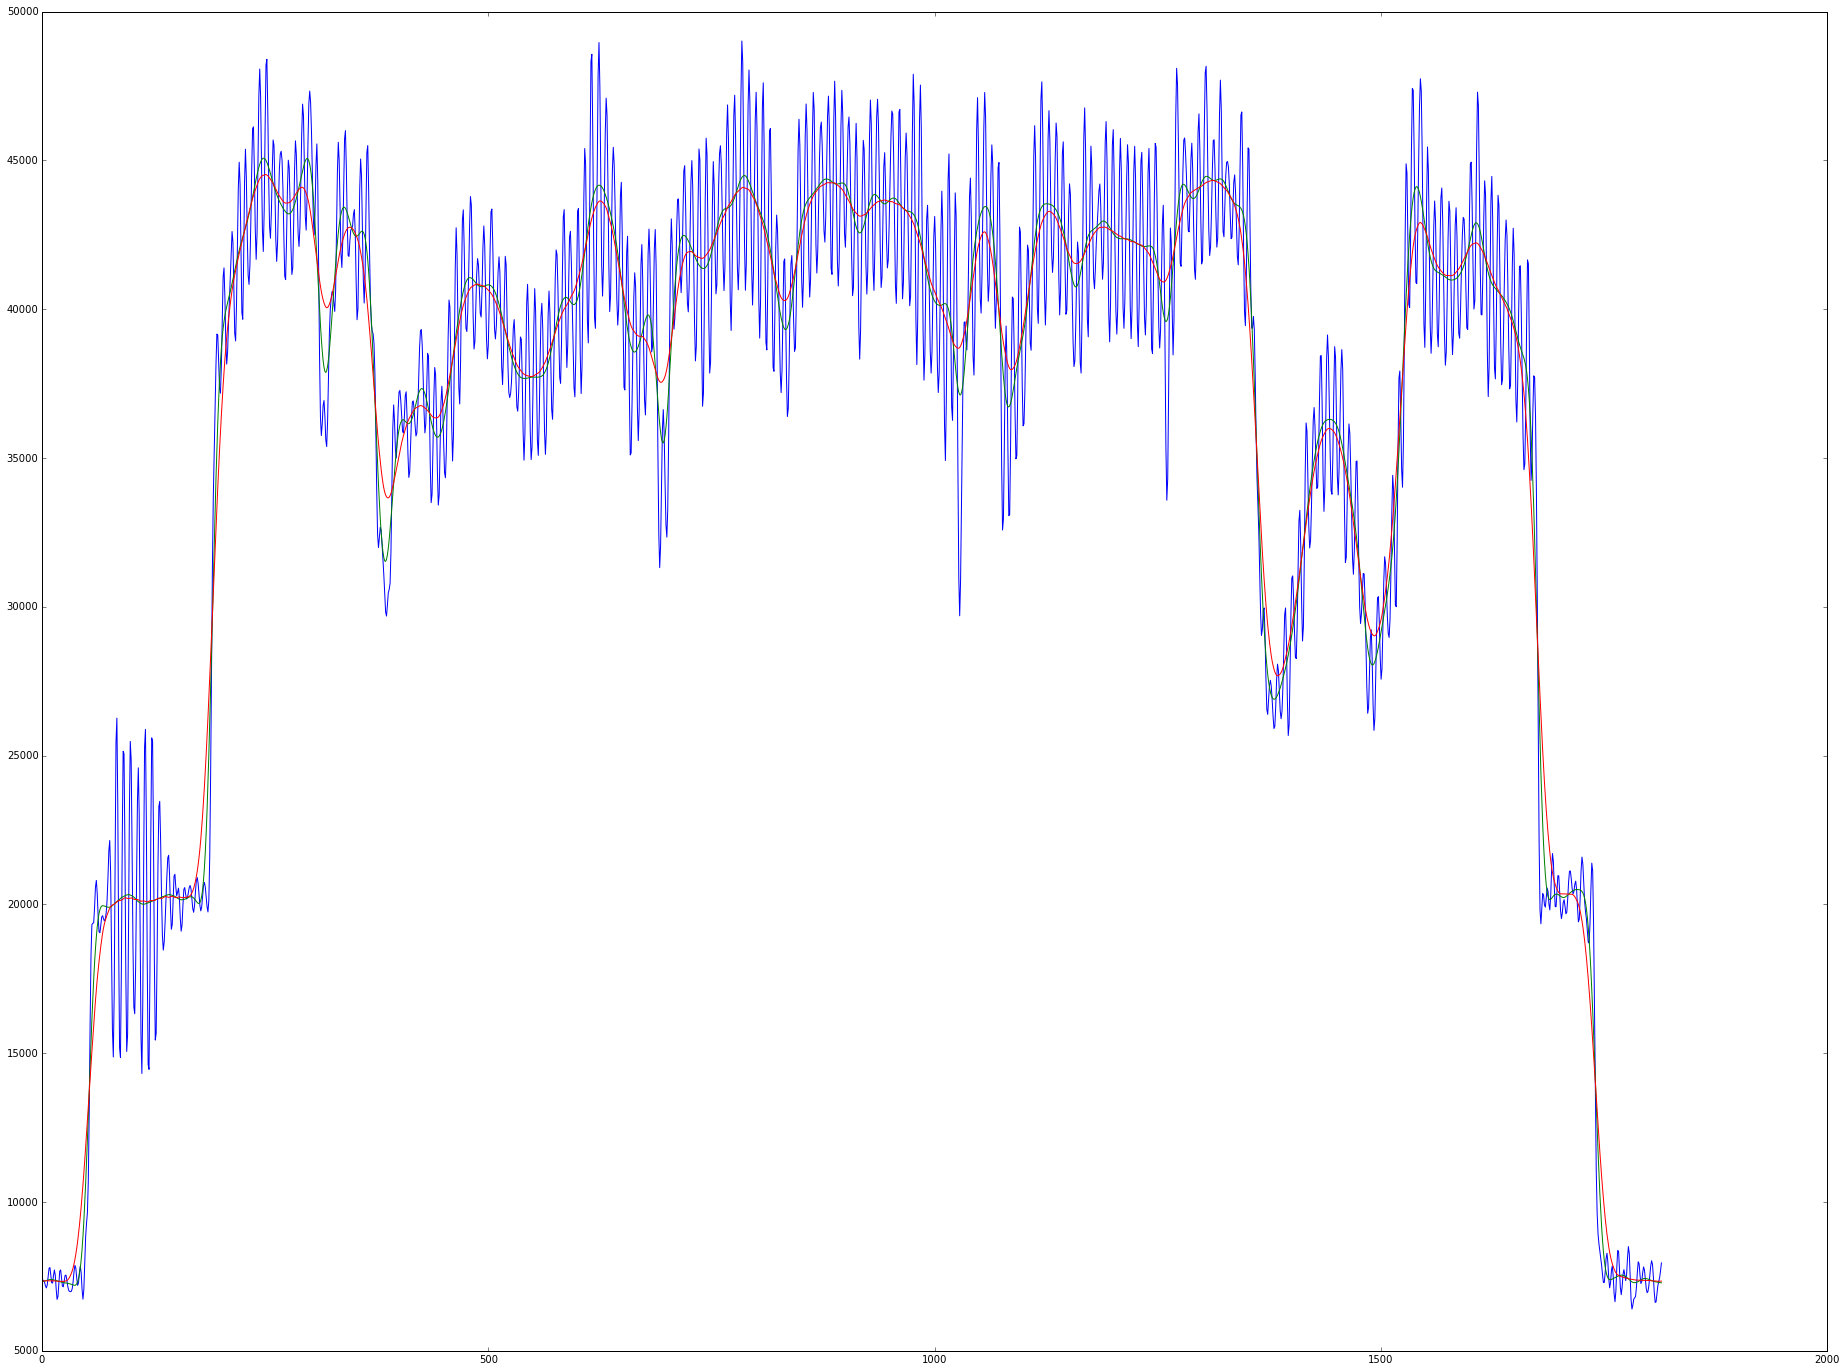

In [607]:
l = 194
plt.plot(data[begin + peaks[l]:begin + peaks[l + 1]])
plt.plot(lpfdata[begin + peaks[l]:begin + peaks[l + 1]])
plt.plot(slpfdata[begin + peaks[l]:begin + peaks[l + 1]])

In [616]:
lbegin_subset[50:60], np.where(lbegin_subset > IREToRaw(-20))[0][0]

(array([ 10414.10435761,  10792.34360403,  11191.98285168,  11608.71844003,
         12038.29851903,  12477.56647442,  12925.32640552,  13382.06699203,
         13848.04667767,  14320.7816233 ]), 57)

In [620]:
offset = (lbegin_subset[57] - IREToRaw(-20)) / (lbegin_subset[57] - lbegin_subset[56])
57 - offset

56.395571577861446

In [621]:
IREToRaw(-20)

13106

In [809]:
burst_detect(data[bbegin:bend])

/home/cpage/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


[2708.4921456900715, 3.050265449751469]

/home/cpage/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


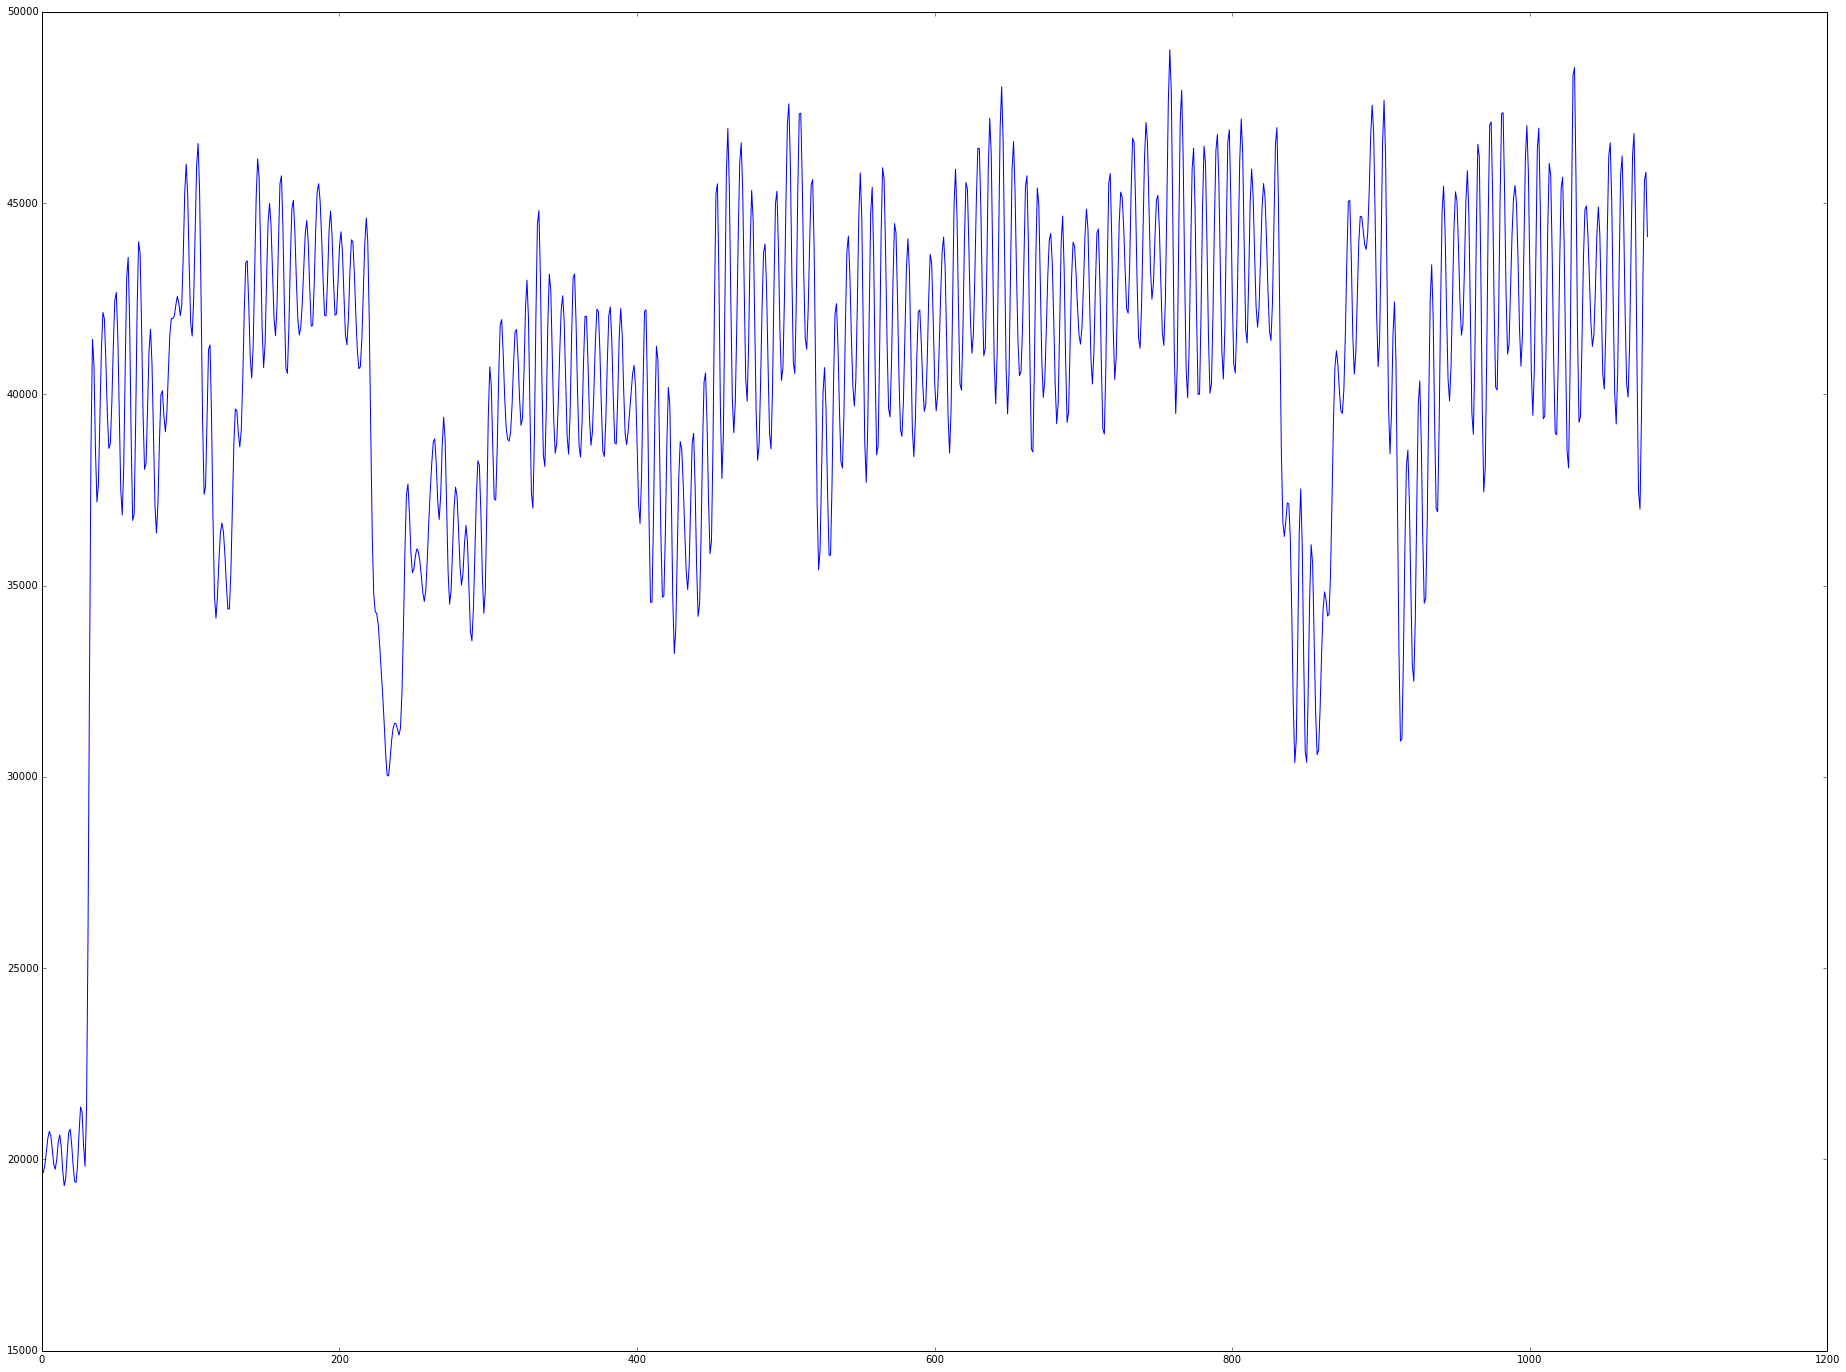

In [686]:
plt.plot(data[bbegin-500:bend+500])

In [692]:
burstfreq = 1000000 * 315/88.0

# This filter focuses on the color burst in an attempt to improve alignment on noisy disks
f_burst_bpf_b = sps.firwin(49, [(burstfreq-250000)/freq_hz, (burstfreq+250000)/freq_hz])
f_burst_bpf_a = [1.0]
f_burst_bpf_offset = 24


In [749]:
(1920 / 1820)

1.054945054945055

In [826]:
burst_detect(sline1[20:100])

[2613.0134482869357, 3.1338181020841307]

In [843]:
burst_detect(sline1[28:90])

[2611.7869750961445, 3.1338144511465389]

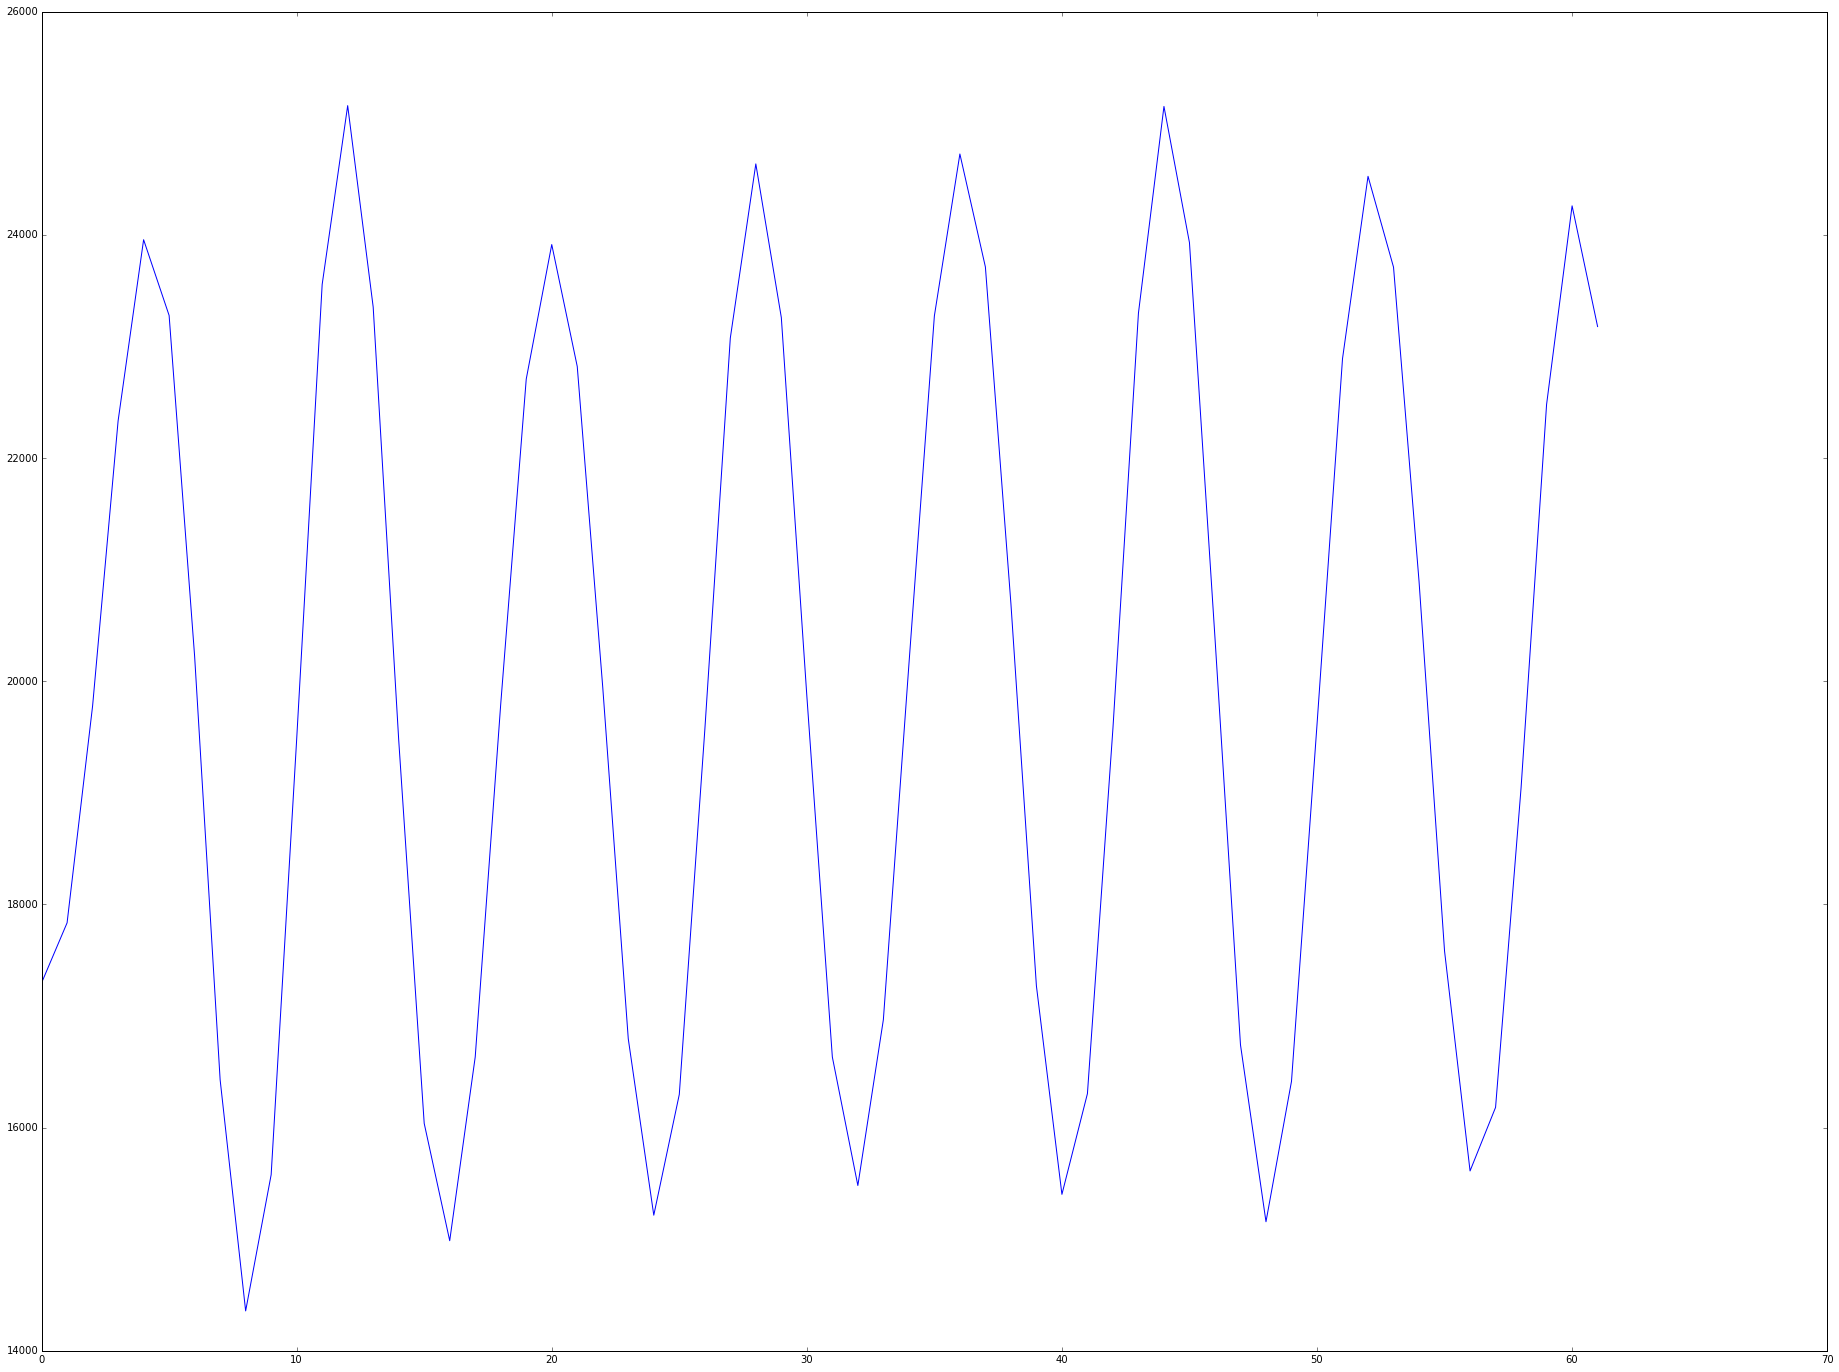

In [842]:
plt.plot(sline1[28:90])

In [18]:
postsync

256463

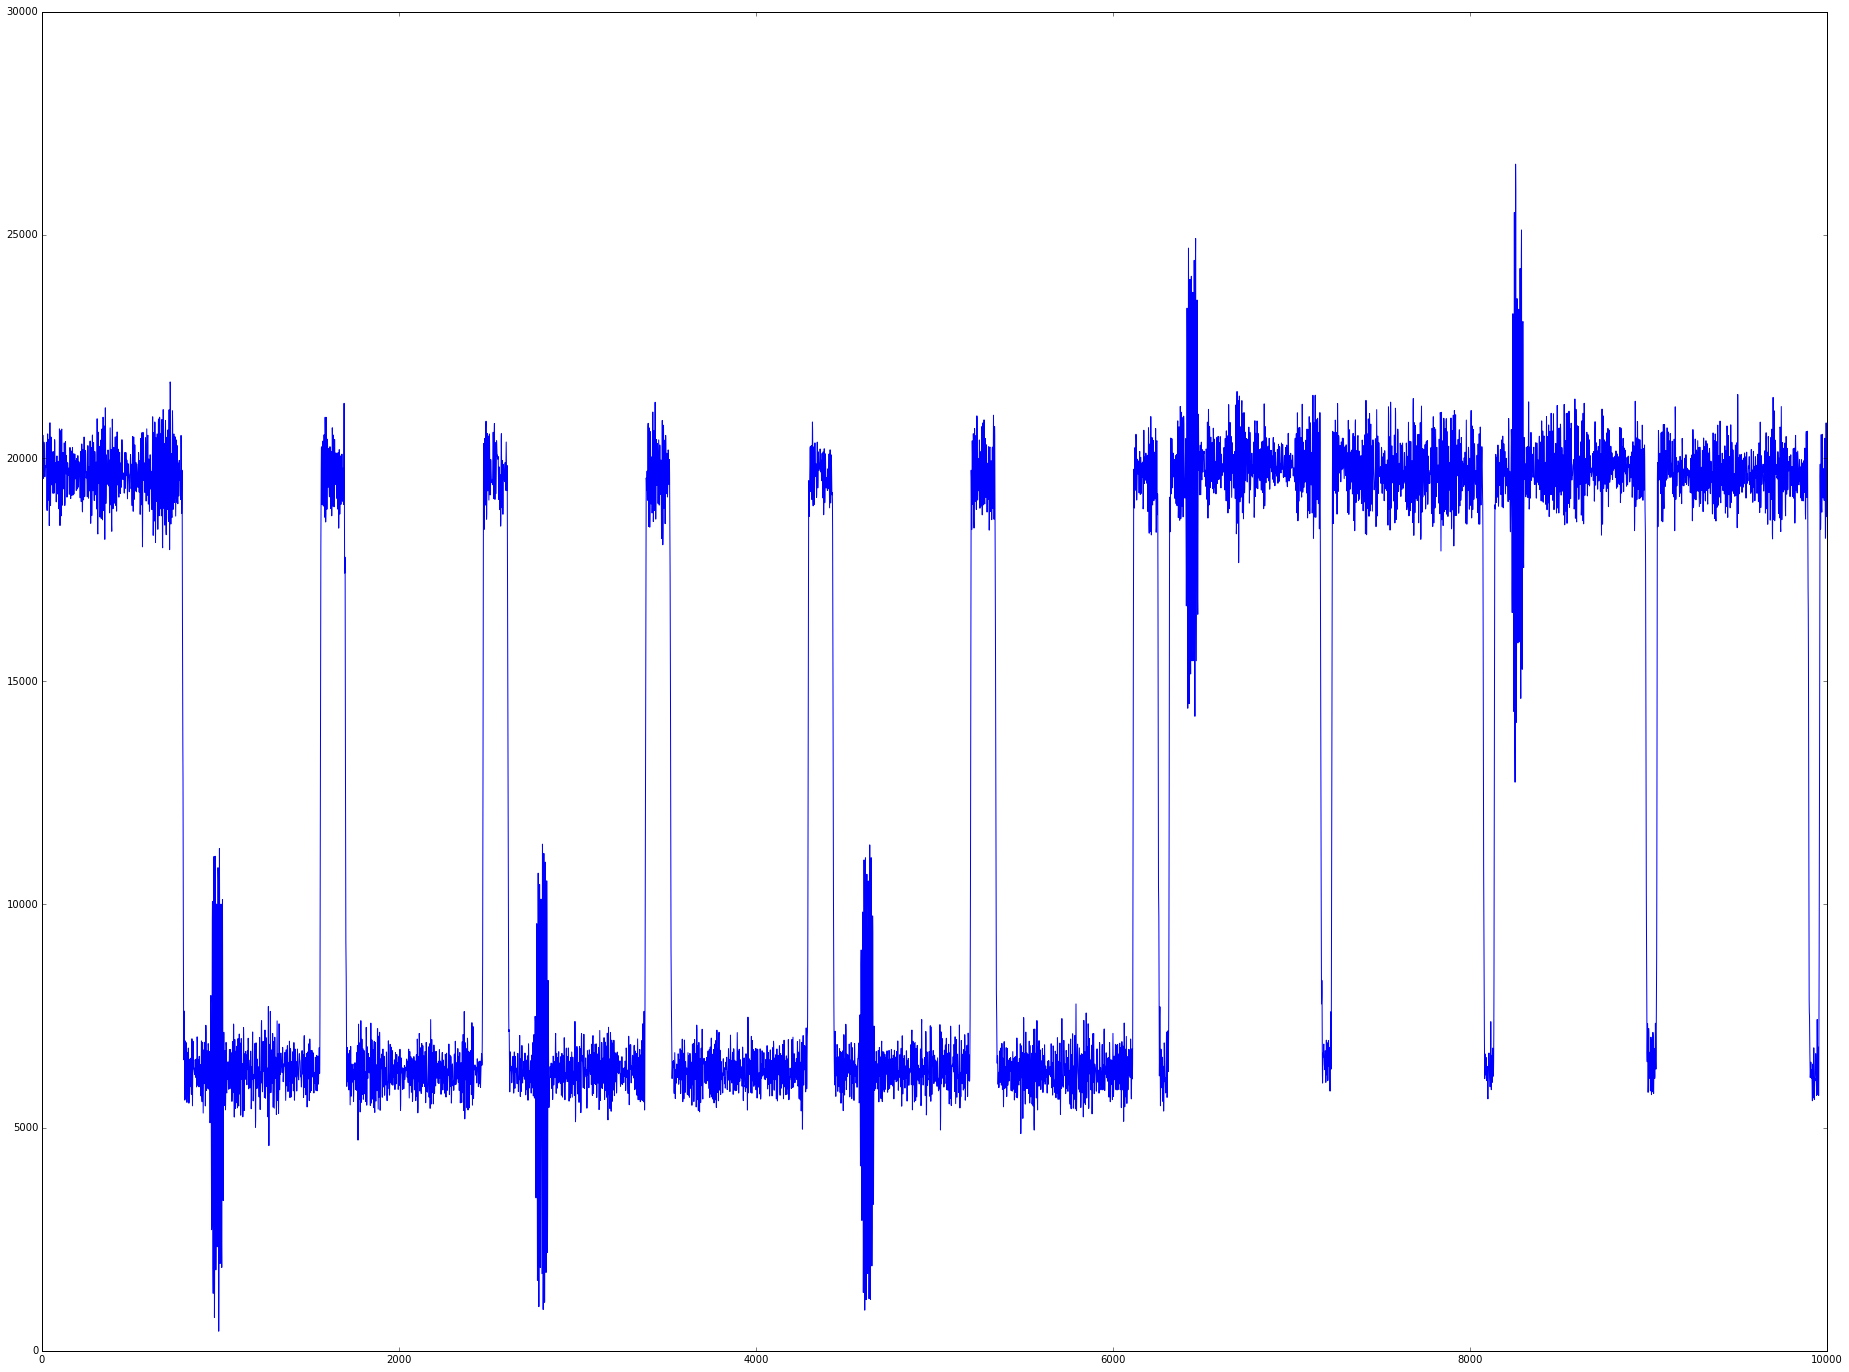

In [94]:
plt.plot(data[250000:260000])

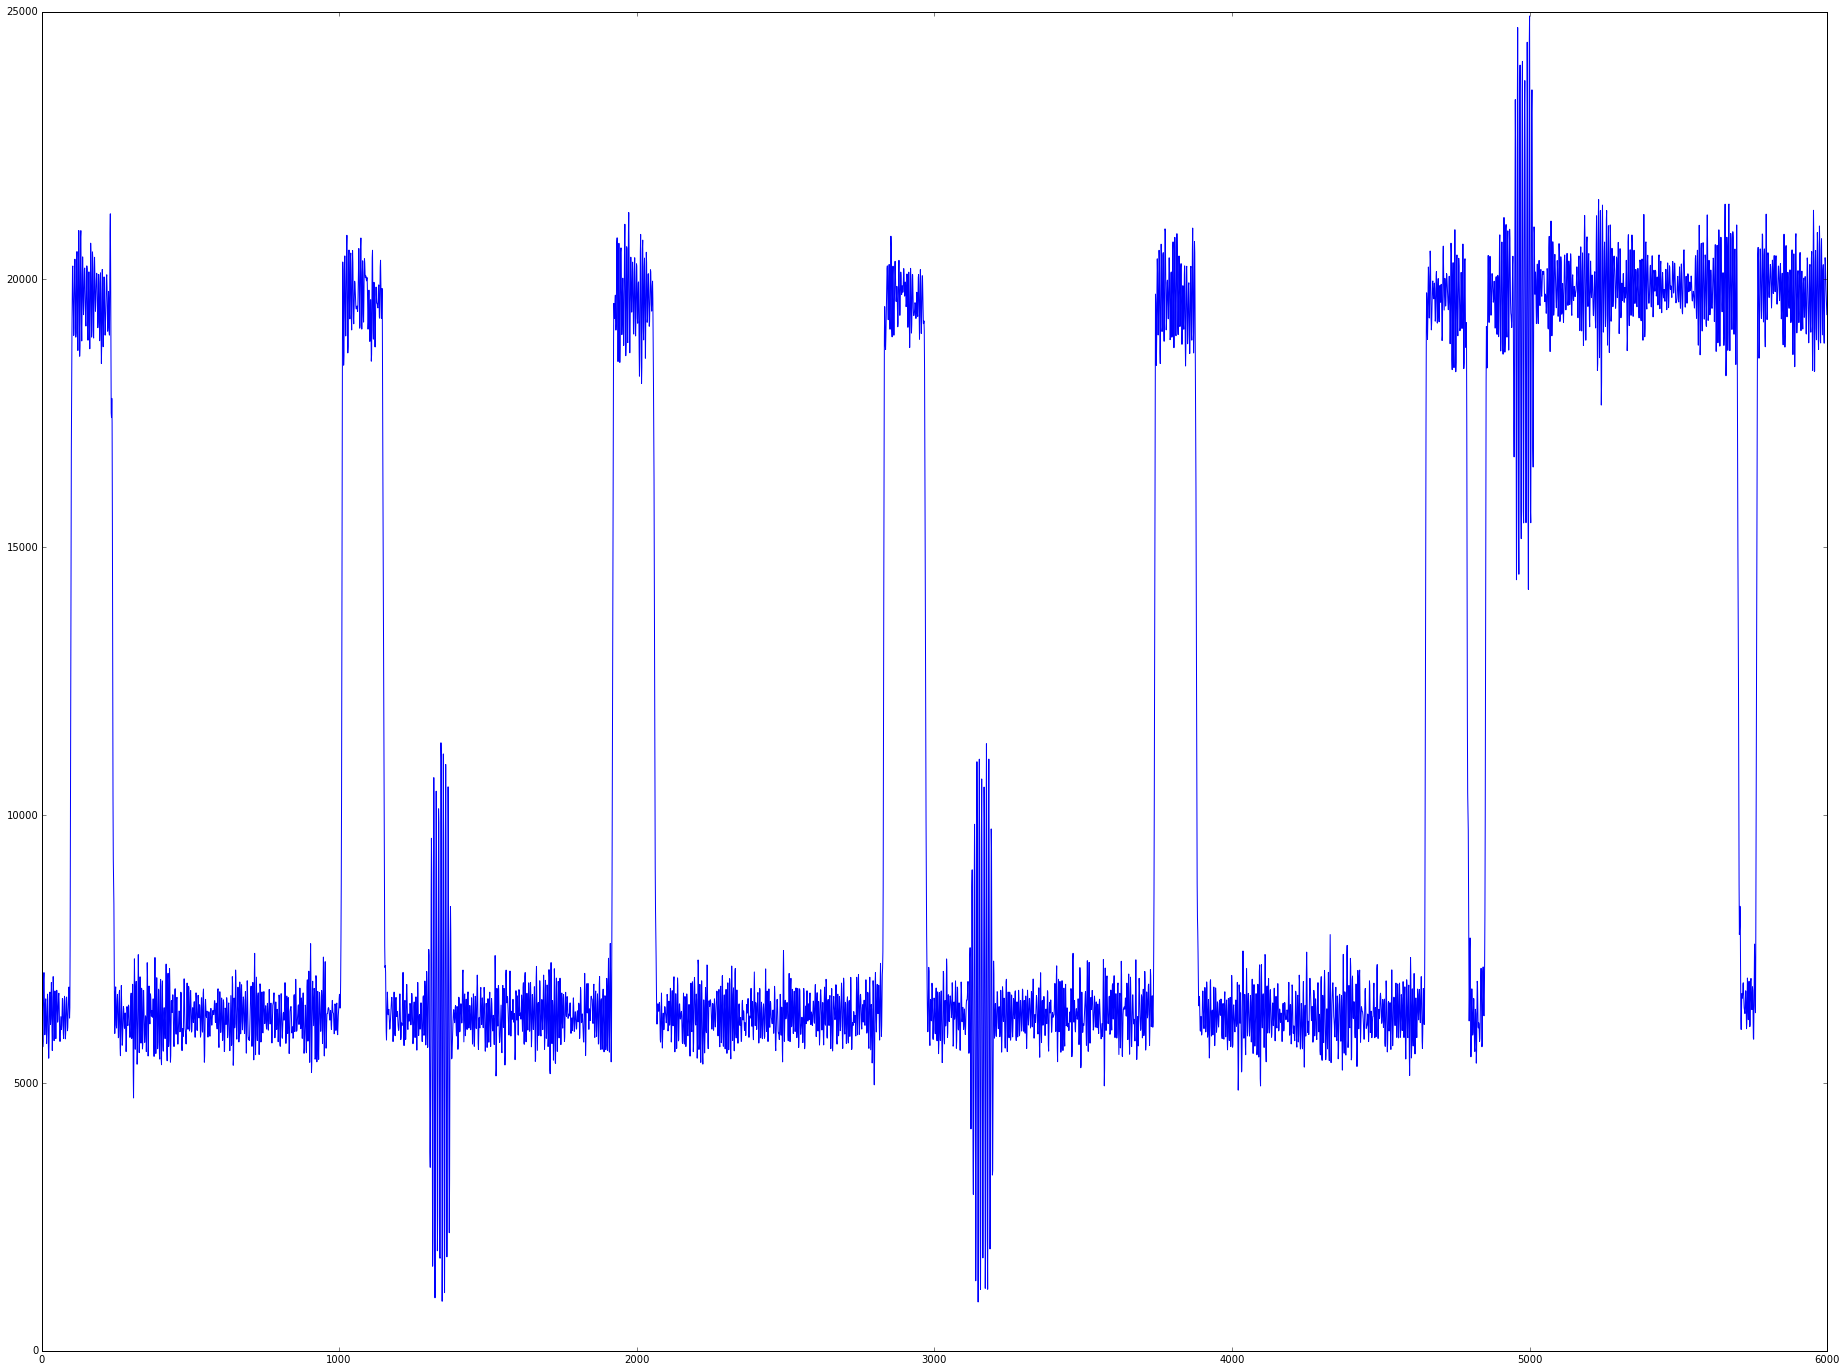

In [23]:
plt.plot(data[postsync - 5000: postsync + 1000])

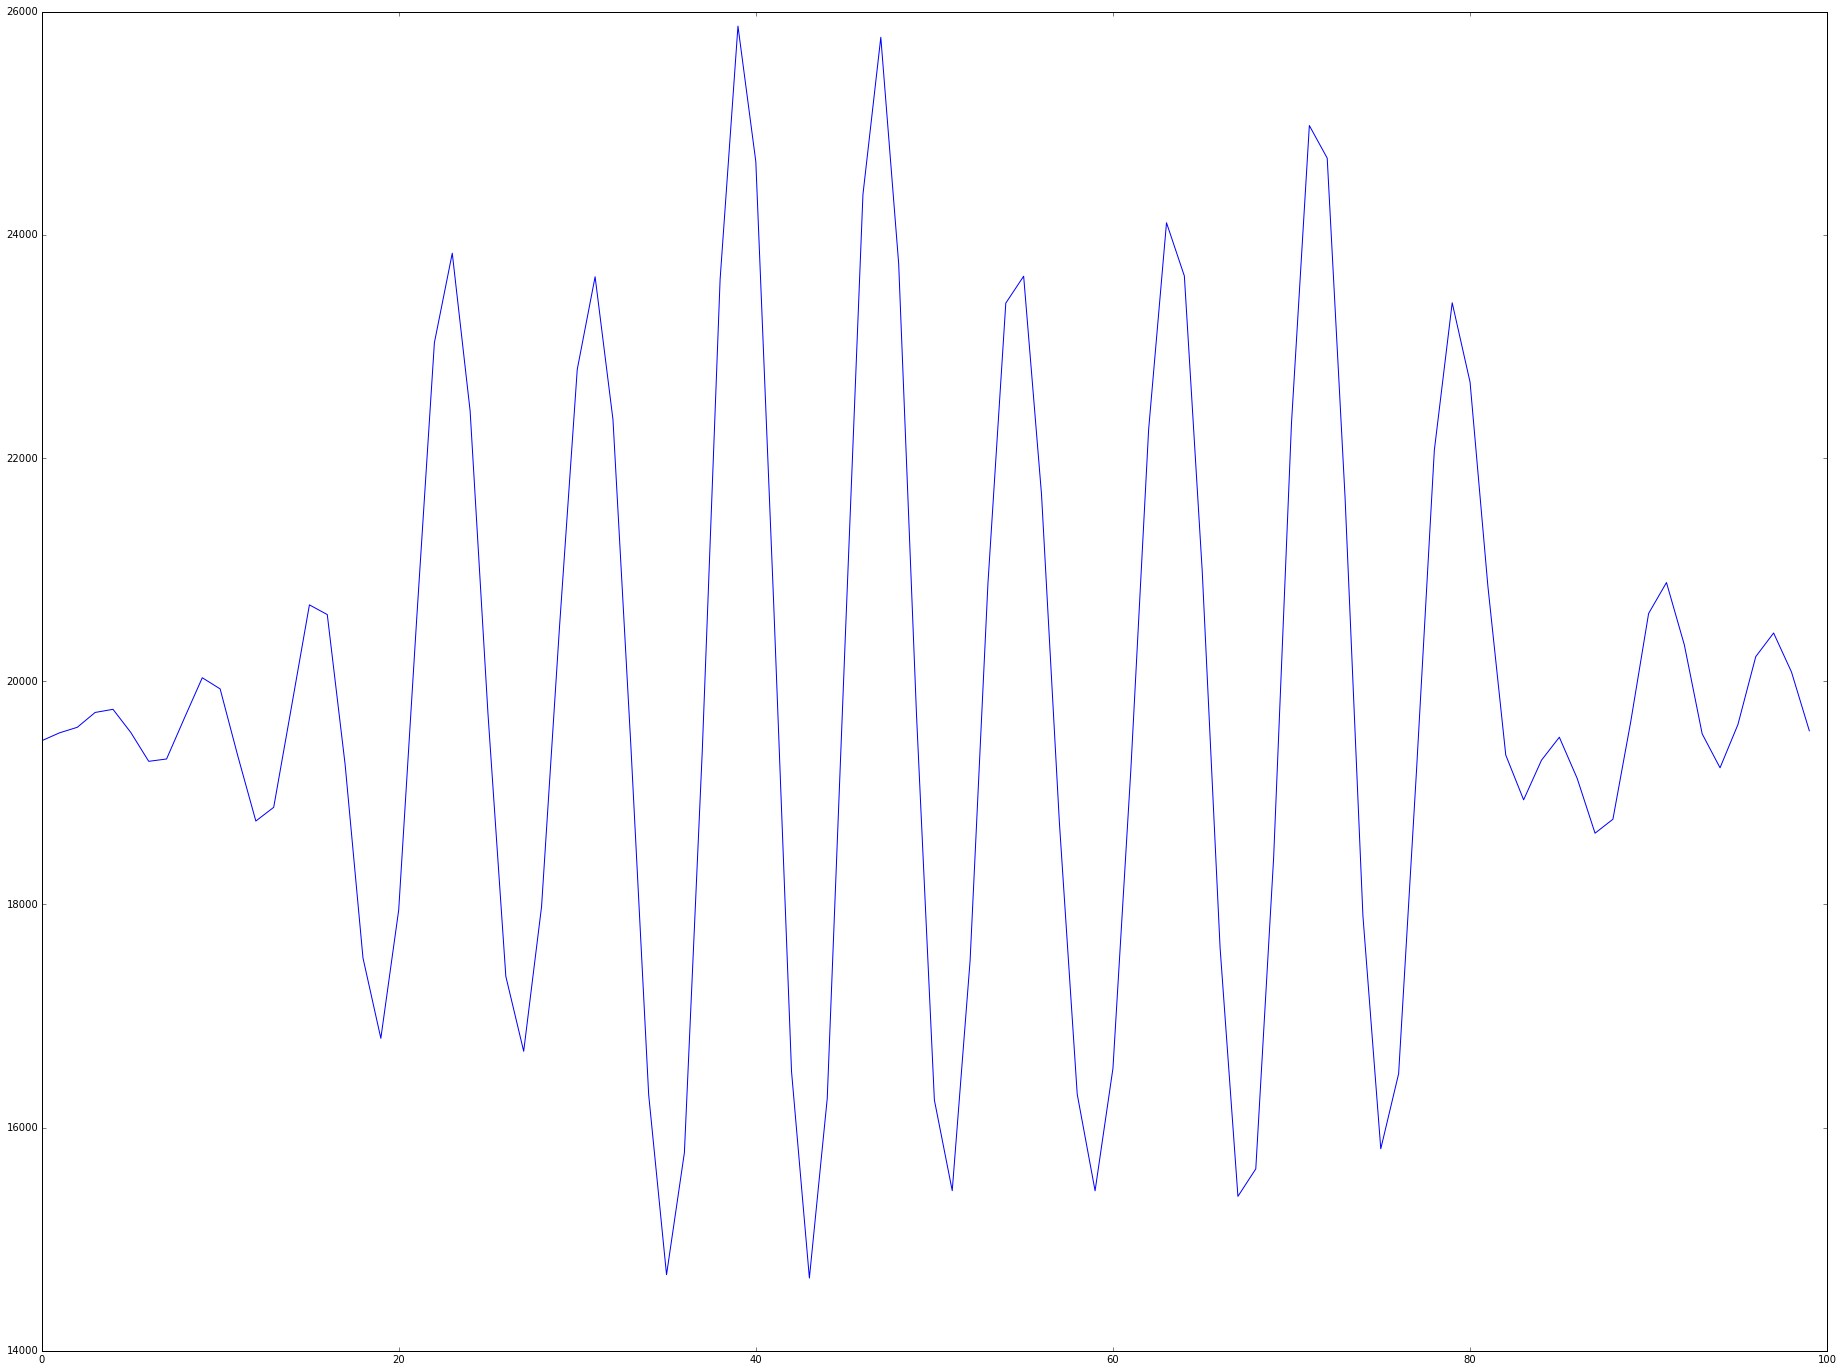

In [306]:
plt.plot(data[begin+441242:begin+441242+100])